In [1]:
import sys, os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from rdflib.plugins.stores import sparqlstore, memory
import rdflib
from rdflib import URIRef, Literal, Graph, Dataset

import serialization
import discourse

import html
import loader
import discourse
import pandas as pd
from rdflib import Graph, Namespace
from rdflib.namespace import RDF, RDFS
import io
import pydotplus
from IPython.display import display, Image
from rdflib.tools.rdf2dot import rdf2dot
from IPython.core.display import HTML

import uuid

from urllib.error import HTTPError
import xml.etree.ElementTree as ET

from itertools import chain

from datetime import datetime

def visualize(g):
    stream = io.StringIO()
    rdf2dot(g, stream, opts = {display})
    dg = pydotplus.graph_from_dot_data(stream.getvalue())
    png = dg.create_png()

    display(Image(png))

def t2rdflibg(triples): #triples to rdflib graph
    g = Graph()
    for t in triples:
        g.add(t)
    return g


def nan2None(value):
    if pd.isnull(value) :
        return None
    else:
        return value


def get_data_rows(filename):
    data_rows_df = pd.read_csv(filename)
    data_rows=[]
    for i,r in data_rows_df.iterrows():
        r_d = {k:nan2None(v) for k,v in dict(r).items()}

        data_rows.append(r_d)
    del data_rows_df
    return data_rows

store_type="memory"

if store_type=="jena":
    g_store = sparqlstore.SPARQLUpdateStore("http://localhost:3030/modelg/query",context_aware=True)
    g_store.open(("http://localhost:3030/modelg/query", "http://localhost:3030/modelg/update"))
    #jena.open(("http://localhost:3030/models/query", "http://localhost:3030/models/update"))
elif store_type=="memory":
    g_store = memory.Memory()


# Create a Dataset
ds = Dataset(store=g_store, default_union=True, default_graph_base="http://base.raw")
#ds = Dataset(store=jena, default_union=True)
# Define a named graph within the dataset, this will contain all nodes contained within the graph referenced, or none if it doesn't exist yet.
sg_uri = "http://config"
masterg_uri = "http://master"
discourseg_uri = "http://discourse"



* Owlready2 * Warning: optimized Cython parser module 'owlready2_optimized' is not available, defaulting to slower Python implementation
* Owlready2 * WARNING: ObjectProperty http://www.semanticweb.org/tomk/ontologies/2022/11/serialization#MappingMetaTarget belongs to more than one entity types: [owl.AnnotationProperty, owl.ObjectProperty, owl.topObjectProperty]; I'm trying to fix it...
* Owlready2 * Running HermiT...
    java -Xmx2000M -cp /home/tomk/environment/devpy/lib/python3.10/site-packages/owlready2/hermit:/home/tomk/environment/devpy/lib/python3.10/site-packages/owlready2/hermit/HermiT.jar org.semanticweb.HermiT.cli.CommandLine -c -O -D -I file:////tmp/tmp_hyz8od6


Serialization.Meta [Serialization.SerializationMetaData]
Serialization.TranslationMapping [Serialization.SerializationSpecs]
Serialization.MappingKVPair [Serialization.SerializationSpecs]
Serialization.Serialization [Serialization.SerializationSpecs]
Serialization.Mapping [Serialization.SerializationSpecs]
Serialization.BatchDefinition [Serialization.SerializationSpecs]
Serialization.SerializationSpecs [Serialization.SerializationMetaData]
Serialization.BatchNode [Serialization.DataLoad]
Serialization.DataLoad [Serialization.SerializationMetaData]
Serialization.SerializationMetaData [owl.Thing]
Serialization.DataPropertyMapping [Serialization.Mapping]
Serialization.MetaDataProperty [Serialization.Meta]
Serialization.EntityMapping [Serialization.Mapping]
Serialization.MetaClass [Serialization.Meta]
Serialization.JobNode [Serialization.DataLoad]
Serialization.MetaProperty [Serialization.Meta]
Serialization.MetaStaticProperty [Serialization.Meta]
Serialization.PropertyMapping [Serializati

* Owlready2 * HermiT took 0.6106603145599365 seconds
* Owlready * (NB: only changes on entities loaded in Python are shown, other changes are done but not listed)


In [2]:
def meta_data_package_template(field_d):
    dc_terms_base = "http://purl.org/dc/terms/"
    rdf_form = {}
    for k,v in field_d.items():
        rdf_form[URIRef(dc_terms_base + k)] = Literal(v)
    return rdf_form


def triples_to_quads(triples, graph="http://master"):
    for s,p,o, *_ in triples:
        yield (s,p,o,URIRef(graph))

In [3]:
# We need to populate the config graph with some contents from an rdf file, if it's not already populated
# This method is incredibly slow, but (should) only be necessary on the occasions where the database
# is being populated from scratch. There are probably better ways to insert contents of a graph into the db
# and this might be something to revisit later on. 
sg = ds.graph(URIRef(sg_uri))
if len(sg)==0:
    sg.parse("DMEAR_ser.rdf")
#S = serialization.Serialization(sg, "EntityAttributeRecord")

In [4]:
mg = ds.graph(URIRef(masterg_uri))
if len(mg)==0:
    mg.parse("master_graph.rdf")

In [5]:
dg = ds.graph(URIRef(discourseg_uri))
if len(dg)==0:
    dg.parse("discourse_graph.rdf")

In [6]:
file_dtypes = {'ModelDomain': str,
 'Model': str,
 'ModelType': str,
 'Class': str,
 'ClassDescription': str,
 'Attribute': str,
 'AttributeDescription': str,
 'DataType': str,
 'Context': str,
 'SubContext': str,
 'Nulls': str,
 'Is PK': str,
 'Relationship': str,
 'FromClass': str,
 'FromAttribute': str,
 'FromCardinality': str,
 'ToClass': str,
 'ToAttribute': str,
 'ToCardinality': str}

In [7]:
def get_field(v):
    if isinstance(v,str):
        return html.escape(str(v))
    elif isinstance(v,(int, float)):
        if pd.isnull(v):
            return None
        else:
            return v
    elif v is None or isinstance(v,pd.Null):
        return None

In [8]:
# Optional Delete data hosted in master and discourse database graphs
do="Yes"
#do="No"

if do == "Yes" and store_type != "memory":
    try:
        ds.update("""CLEAR GRAPH <http://master>""")
    except HTTPError:
        pass
    ds.update("""CREATE GRAPH <http://master>""")
    try:
        ds.update("""CLEAR GRAPH <http://discourse>""")
    except HTTPError:
        pass
    ds.update("""CREATE GRAPH <http://discourse>""")

In [9]:
#ds = Dataset(store=jena, default_union=True, default_graph_base="http://base.raw")
#master_g = ds.graph(URIRef("http://master"))
#discourse_g = ds.graph(URIRef("http://discourse"))

### Is this necessary? If graphs are created when master and discourse graph rdf files are parsed?

rs = ds.query("""select distinct ?g WHERE { GRAPH ?g { ?s ?p ?o .}}""")
rg_set = set(pd.DataFrame(rs, columns=["graph"])['graph'].apply(lambda x : x.n3()[1:-1]))
required_graphs = ["http://master", "http://discourse"]



for g in required_graphs:
    if g not in rg_set:
        print(g)
#        tg = ds.graph(URIRef(g))
        if store_type == "jena":
            create_graph_sparql = """CREATE GRAPH {gn}""".format(gn=URIRef(g).n3())
            print(create_graph_sparql)
            ds.update(create_graph_sparql)

rs = ds.query("""select distinct ?g WHERE { GRAPH ?g { ?s ?p ?o .}}""")
rg_set = set(pd.DataFrame(rs, columns=["graph"])['graph'].apply(lambda x : x.n3()[1:-1]))
rg_set

{'http://config', 'http://discourse', 'http://master'}

In [10]:
discourse_details_sparql = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX disco: <http://www.semanticweb.org/tomk/ontologies/2022/11/discourse#> 
PREFIX dcterms: <http://purl.org/dc/terms/> 
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> 

select ?g ?discourse ?name ?title ?description ?created ?hash (COUNT(?declaration) as ?declarations) (COUNT(distinct ?psubject) as ?entities)

WHERE {
  GRAPH ?g
  {
      ?discourse a disco:Discourse.
      ?discourse dcterms:title ?title.
      ?discourse rdfs:label ?name.
      ?discourse dcterms:description ?description.
      ?discourse dcterms:created ?created .
      ?discourse disco:DiscourseHash ?hash .
      ?discourse disco:DiscourseContains+ ?declaration .
      ?declaration a disco:Declaration .
      ?posit_type rdfs:subPropertyOf* disco:Posits .
      ?declaration disco:Asserts ?assertion.
      ?assertion disco:Subject ?psubject.
  }
}
GROUP BY ?g ?discourse ?name ?title ?description ?created ?hash
"""

qr = ds.query(discourse_details_sparql)
discourse_df = pd.DataFrame(qr, columns=[v.n3()[1:] for v in qr.vars]).sort_values(by="created")
discourse_df["hash_vals"]=discourse_df['hash'].apply(lambda x : x.n3()[1:-1])
discourse_df.set_index("discourse", inplace=True)
discourse_df
hash_discourse_mapping = {v:k for k,v in dict(discourse_df['hash'].apply(lambda x : x.n3()[1:-1])).items()}


In [11]:
hash_discourse_mapping

{}

In [12]:
mg._Graph__identifier

rdflib.term.URIRef('http://master')

In [13]:
assert False

AssertionError: 

In [ ]:
title = "Inventory ERD v1.0"
model_data = pd.read_csv(r"../sample/inventory_v1.csv", index_col="Sequence", dtype=file_dtypes)
rows = [dict({rk:get_field(rv) for rk, rv in r.items()}) for i,r in model_data.iterrows()]
md_p = meta_data_package_template( {"created" : "2023-04-10", 
                                   "creator" : "tomk", 
                                   "description" : "Sample ERD model version 1", 
                                   "title" : "inventory ERD", 
                                   "modified" : "2023-04-10"})

loader.load_to_graph(ds, sg_uri, "EntityAttributeRecord", rows, masterg_uri, discourseg_uri, title, md_p, hash_discourse_mapping, override_duplicate=False)



In [ ]:
rows

In [14]:
rows=[{"ParentClass" : "Human", 
       "Class" : "Grandad", 
       "SubClassPointer" : "a", 
       "Property" : "Granny", 
       "DataProperty" : "Tony"},
      {"ParentClass" : "Human", 
       "Class" : "Granny", 
       "SubClassPointer" : "b", 
       "Property" : "Grandad", 
       "DataProperty" : "Audrey"},
       {"ParentClass" : "Human", 
       "Class" : "Me", 
       "SubClassPointer" : "c", 
       "Property" : "Lisa", 
       "DataProperty" : "Tom"},
       {"ParentClass" : "Human", 
       "Class" : "Freddie", 
       "SubClassPointer" : "a", 
       "Property" : "Me", 
       "DataProperty" : "Fred"}, 
       {"ParentClass" : "Human", 
       "Class" : "Lisa", 
       "SubClassPointer" : "a", 
       "Property" : "Me", 
       "DataProperty" : "Test"}
]

In [15]:
"http://www.semanticweb.org/tomk/ontologies/2022/11/serialization#MetaClass"=='http://www.semanticweb.org/tomk/ontologies/2022/11/serialization#MetaClass'

True

In [16]:
alt_sg = None
alt_sg = ds.graph(URIRef(sg_uri))
serns = Namespace(serialization.serial.base_iri)
alt_sg.bind('ser', serns, override=True, replace=True)
alt_sg.parse("../sample_ser.rdf")
serialization_graph_uri = sg_uri
S = serialization.Serialization(alt_sg, "Sample Serialisation")

Parent_Class_Mapping is a  class
Class_Mapping is a  class
SubClassProperty_Mapping is a  staticproperty
Property_Mapping is a  property
{rdflib.term.URIRef('http://www.w3.org/2002/07/owl#NamedIndividual'), rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/serialization#MetaDataProperty')}
dataproperty
DataProperty_Mapping
DataProperty_Mapping is a  dataproperty
translation_mapping_ids ['http://www.semanticweb.org/tomk/ontologies/2023/6/sample#Sample_Serialisationb74fc8d126b2456bafd1e1e7282b5a61', 'http://www.semanticweb.org/tomk/ontologies/2023/6/sample#Sample_Serialisation392abdadb4a1431dae794d39ae2d99c5']
http://www.semanticweb.org/tomk/ontologies/2023/6/sample#Sample_Serialisationb74fc8d126b2456bafd1e1e7282b5a61
http://www.semanticweb.org/tomk/ontologies/2023/6/sample#Sample_Serialisation392abdadb4a1431dae794d39ae2d99c5
****************************************
<http://config> a rdfg:Graph;rdflib:storage [a rdflib:Store;rdfs:label 'Memory'].
This is the Serializ

In [17]:
serialization.serial.TranslationMapping.iri, "http://www.semanticweb.org/tomk/ontologies/2022/11/serialization#TranslationMapping"

('http://www.semanticweb.org/tomk/ontologies/2022/11/serialization#TranslationMapping',
 'http://www.semanticweb.org/tomk/ontologies/2022/11/serialization#TranslationMapping')

In [20]:
md_p = meta_data_package_template( {"created" : "2023-08-17", 
                                   "creator" : "tomk", 
                                   "description" : "Test sample serialization", 
                                   "title" : "test3", 
                                   "modified" : "2023-04-10"})

loader.load_to_graph(ds, sg_uri, "Sample Serialisation", rows, masterg_uri, discourseg_uri, "sample test", md_p, hash_discourse_mapping, override_duplicate=False)



Parent_Class_Mapping is a  class
Class_Mapping is a  class
SubClassProperty_Mapping is a  staticproperty
Property_Mapping is a  property
{rdflib.term.URIRef('http://www.w3.org/2002/07/owl#NamedIndividual'), rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/serialization#MetaDataProperty')}
dataproperty
DataProperty_Mapping
DataProperty_Mapping is a  dataproperty
translation_mapping_ids ['http://www.semanticweb.org/tomk/ontologies/2023/6/sample#Sample_Serialisationb74fc8d126b2456bafd1e1e7282b5a61', 'http://www.semanticweb.org/tomk/ontologies/2023/6/sample#Sample_Serialisation392abdadb4a1431dae794d39ae2d99c5']
http://www.semanticweb.org/tomk/ontologies/2023/6/sample#Sample_Serialisationb74fc8d126b2456bafd1e1e7282b5a61
http://www.semanticweb.org/tomk/ontologies/2023/6/sample#Sample_Serialisation392abdadb4a1431dae794d39ae2d99c5
****************************************
<http://config> a rdfg:Graph;rdflib:storage [a rdflib:Store;rdfs:label 'Memory'].
This is the Serializ

True

In [ ]:
#g = rdflib.Graph()
#g.parse("sample_ser.rdf")

In [ ]:
sg.bind('ser', serialization.serial.base_iri, override=True, replace=True)
q_results = sg.query("""SELECT distinct ?s
                                WHERE {
                                ?s <rdf:type> ser:TranslationMapping .
                                } """)
pd.DataFrame(q_results)

In [ ]:
title = "Inventory ERD v2.0"
model_data = pd.read_csv(r"../sample/inventory_v2.csv", index_col="Sequence", dtype=file_dtypes)
rows = [dict({rk:get_field(rv) for rk, rv in r.items()}) for i,r in model_data.iterrows()]
md_p = meta_data_package_template( {"created" : "2023-04-11", 
                                   "creator" : "tomk", 
                                   "description" : "Sample ERD model version 2", 
                                   "title" : "inventory ERD", 
                                   "modified" : "2023-04-11"})

loader.load_to_graph(ds, sg_uri, "EntityAttributeRecord", rows, masterg_uri, discourseg_uri, title, md_p, hash_discourse_mapping, override_duplicate=False)



In [ ]:
title = "Inventory ERD v3.0"
model_data = pd.read_csv(r"../sample/inventory_v3.csv", index_col="Sequence", dtype=file_dtypes)
rows = [dict({rk:get_field(rv) for rk, rv in r.items()}) for i,r in model_data.iterrows()]
md_p = meta_data_package_template( {"created" : "2023-04-14", 
                                   "creator" : "tomk", 
                                   "description" : "Sample ERD model version 3", 
                                   "title" : "inventory ERD", 
                                   "modified" : "2023-04-14"})

loader.load_to_graph(ds, sg_uri, "EntityAttributeRecord", rows, masterg_uri, discourseg_uri, title, md_p, hash_discourse_mapping, override_duplicate=False)



In [ ]:
# Step 1 - Tell me what discourses are available in the system

In [ ]:
discourse_details_sparql = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX disco: <http://www.semanticweb.org/tomk/ontologies/2022/11/discourse#> 
PREFIX dcterms: <http://purl.org/dc/terms/> 
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> 

select ?g ?discourse ?name ?title ?description ?created ?hash (COUNT(?declaration) as ?declarations) (COUNT(distinct ?psubject) as ?entities)

WHERE {
  GRAPH ?g
  {
      ?discourse a disco:Discourse.
      ?discourse dcterms:title ?title.
      ?discourse rdfs:label ?name.
      ?discourse dcterms:description ?description.
      ?discourse dcterms:created ?created .
      ?discourse disco:DiscourseHash ?hash .
      ?discourse disco:DiscourseContains+ ?declaration .
      ?declaration a disco:Declaration .
      ?posit_type rdfs:subPropertyOf* disco:Posits .
      ?declaration disco:Asserts ?assertion.
      ?assertion disco:Subject ?psubject.
  }
}
GROUP BY ?g ?discourse ?name ?title ?description ?created ?hash
"""

qr = ds.query(discourse_details_sparql)

In [ ]:
discourse_df = pd.DataFrame(qr, columns=[v.n3()[1:] for v in qr.vars]).sort_values(by="created")
discourse_df

In [ ]:
discourse_details_sparql = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX disco: <http://www.semanticweb.org/tomk/ontologies/2022/11/discourse#> 
PREFIX dcterms: <http://purl.org/dc/terms/> 
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> 

select ?g ?discourse ?name ?title ?description ?created ?hash (COUNT(?declaration) as ?declarations) (COUNT(distinct ?psubject) as ?entities)

WHERE {
  GRAPH ?g
  {
      ?discourse a disco:Discourse.
      ?discourse dcterms:title ?title.
      ?discourse rdfs:label ?name.
      ?discourse dcterms:description ?description.
      ?discourse dcterms:created ?created .
      ?discourse disco:DiscourseHash ?hash .
      ?discourse disco:DiscourseContains+ ?declaration .
      ?declaration a disco:Declaration .
      ?posit_type rdfs:subPropertyOf* disco:Posits .
      ?declaration disco:Asserts ?assertion.
      ?assertion disco:Subject ?psubject.
  }
}
GROUP BY ?g ?discourse ?name ?title ?description ?created ?hash
"""

qr = ds.query(discourse_details_sparql)
discourse_df = pd.DataFrame(qr, columns=[v.n3()[1:] for v in qr.vars]).sort_values(by="created")
discourse_df["hash_vals"]=discourse_df['hash'].apply(lambda x : x.n3()[1:-1])
discourse_df.set_index("discourse", inplace=True)
discourse_df
hash_discourse_mapping = {v:k for k,v in dict(discourse_df['hash'].apply(lambda x : x.n3()[1:-1])).items()}


In [ ]:
title = "Inventory ERD v1.0"
model_data = pd.read_csv(r"../sample/inventory_v1.csv", index_col="Sequence", dtype=file_dtypes)
rows = [dict({rk:get_field(rv) for rk, rv in r.items()}) for i,r in model_data.iterrows()]
md_p = meta_data_package_template( {"created" : "2023-04-10", 
                                   "creator" : "tomk", 
                                   "description" : "Sample ERD model version 1", 
                                   "title" : "inventory ERD", 
                                   "modified" : "2023-04-10"})

loader.load_to_graph(ds, sg_uri, "EntityAttributeRecord", rows, masterg_uri, discourseg_uri, title, md_p, hash_discourse_mapping, override_duplicate=True)



https://docs.data.world/tutorials/sparql/list-of-sparql-filter-functions.html

In [22]:
discourse_details_sparql = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX disco: <http://www.semanticweb.org/tomk/ontologies/2022/11/discourse#> 
PREFIX dcterms: <http://purl.org/dc/terms/> 
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> 

select ?g ?discourse ?name ?title ?description ?created ?hash (COUNT(?declaration) as ?declarations) (COUNT(distinct ?psubject) as ?entities)

WHERE {
  GRAPH ?g
  {
      ?discourse a disco:Discourse.
      ?discourse dcterms:title ?title.
      ?discourse rdfs:label ?name.
      ?discourse dcterms:description ?description.
      ?discourse dcterms:created ?created .
      ?discourse disco:DiscourseHash ?hash .
      ?discourse disco:DiscourseContains+ ?declaration .
      ?declaration a disco:Declaration .
      ?posit_type rdfs:subPropertyOf* disco:Posits .
      ?declaration disco:Asserts ?assertion.
      ?assertion disco:Subject ?psubject.
  }
}
GROUP BY ?g ?discourse ?name ?title ?description ?created ?hash
"""

qr = ds.query(discourse_details_sparql)
discourse_df = pd.DataFrame(qr, columns=[v.n3()[1:] for v in qr.vars]).sort_values(by="created")
discourse_df["hash_vals"]=discourse_df['hash'].apply(lambda x : x.n3()[1:-1])
discourse_df.set_index("discourse", inplace=True)
discourse_df
#hash_discourse_mapping = {v:k for k,v in dict(discourse_df['hash'].apply(lambda x : x.n3()[1:-1])).items()}
discourse_df

,g,name,title,description,created,hash,declarations,entities,hash_vals
discourse,,,,,,,,,
http://www.semanticweb.org/tomk/ontologies/2022/11/a91d420770c0491e8dd433247dfdff71,http://discourse,discourse_sample test,test3,Test sample serialization,2023-08-17,6889242f6d41-ca26-5156-3cc6d78e7e65,28,6,6889242f6d41-ca26-5156-3cc6d78e7e65


In [23]:
discourses = list(discourse_df.index)
discourses

[rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/a91d420770c0491e8dd433247dfdff71')]

In [24]:
d82658e7a30c497a9a341890208d6d47

NameError: name 'd82658e7a30c497a9a341890208d6d47' is not defined

In [25]:


get_discourse_posits_sparql = """

PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX disco: <http://www.semanticweb.org/tomk/ontologies/2022/11/discourse#> 
PREFIX dcterms: <http://purl.org/dc/terms/> 
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> 


select ?g ?discourse ?a ?r ?p
WHERE {
  GRAPH ?g
  {
      ?discourse a disco:Discourse.
      ?discourse disco:DiscourseContains+ ?declaration .
      ?declaration a disco:Declaration .
        OPTIONAL { ?declaration disco:Asserts ?a. 
                   }
        OPTIONAL { ?declaration disco:Refutes ?r. 
                   }
        OPTIONAL { ?declaration disco:Posits ?p. 
        }
      
  }
}

"""

qr = ds.query(get_discourse_posits_sparql)

pd.DataFrame(qr, columns=["g","d","a","r","p"]).groupby(["g","d"]).agg(set)#.iloc[2]['a']


,,a,r,p
g,d,,,
http://discourse,http://www.semanticweb.org/tomk/ontologies/2022/11/a91d420770c0491e8dd433247dfdff71,{http://www.semanticweb.org/tomk/ontologies/20...,{None},{None}


In [26]:
av = pd.DataFrame(qr, columns=["g","d","a","r","p"]).groupby(["g","d"]).agg(set)[['a']].values
for i,x in enumerate(av):
    for j,y in enumerate(av):
        if i!=j:
            print((i,j),len(set(x[0]).difference(set(y[0]))), len(set(x[0]).intersection(set(y[0]))), len(set(y[0]).difference(set(x[0]))))
        

In [27]:
# Given two discourse urls, d1, d2, pull all the discourse-data associated 
# - including the reified triples they reference


get_posits_by_discourse_sparql = """

PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX disco: <http://www.semanticweb.org/tomk/ontologies/2022/11/discourse#> 
PREFIX dcterms: <http://purl.org/dc/terms/> 
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> 

select ?g ?discourse ?assertion ?refutation ?posit ?s ?p ?o
WHERE {
  GRAPH ?g
  {
      ?discourse a disco:Discourse.
      ?discourse disco:DiscourseContains+ ?declaration .
      ?declaration a disco:Declaration .
        OPTIONAL { ?declaration disco:Asserts ?assertion. 
                   ?assertion disco:Subject ?s.
                   ?assertion disco:Predicate ?p.
                   ?assertion disco:Object ?o.
                   }
        OPTIONAL { ?declaration disco:Refutes ?refutation. 
                   ?refutation disco:Subject ?s.
                   ?refutation disco:Predicate ?p.
                   ?refutation disco:Object ?o.
                   }
        OPTIONAL { ?declaration disco:Posits ?posit. 
                   ?posit disco:Subject ?s.
                   ?posit disco:Predicate ?p.
                   ?posit disco:Object ?o.
        }
      FILTER (?discourse IN ( %%d1%%, %%d2%% )) .
      
  }
}

""".replace("%%d1%%",discourses[0].n3()).replace("%%d2%%", discourses[0].n3())

qr = ds.query(get_posits_by_discourse_sparql)

In [28]:
[v.n3() for v in qr.vars]

['?g', '?discourse', '?assertion', '?refutation', '?posit', '?s', '?p', '?o']

In [29]:
def return_vars(var_cols):
    if store_type=="memory":
        varpul=lambda x : x[1:]
    else:
        varpul=lambda x : x
    return [varpul(v.n3())for v in var_cols]
    
discourse_contents = pd.DataFrame(qr, columns=return_vars(qr.vars))#.sort_values(by="discourse")
set(discourse_contents['discourse'])
#discourse_contents

{rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/a91d420770c0491e8dd433247dfdff71')}

In [30]:
set(discourse_contents.set_index("discourse").loc[rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/a91d420770c0491e8dd433247dfdff71')]['p'].values)

{rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/serialization#UniqueIdentifier'),
 rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2023/6/sample#someDataProperty'),
 rdflib.term.URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#type'),
 rdflib.term.URIRef('http://www.w3.org/2000/01/rdf-schema#label')}

In [31]:
discourse_contents['triple'] = discourse_contents.apply(lambda x : tuple([x['s'], x['p'], x['o']]), axis=1)

In [32]:
d_set_d = discourse_contents.groupby(['discourse'])['triple'].agg(set).to_dict()


#d_set_d = discourse_contents.groupby(['discourse']).agg(set).to_dict()


In [33]:
key_l = list(d_set_d.keys())
key_l

[rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/a91d420770c0491e8dd433247dfdff71')]

In [34]:
def diffset(S1, S2):
    # Given two input sets, s1 and s2, return the Left difference, Intersection and Right difference between them
    L = S1.difference(S2)
    I = S1.intersection(S2)
    R = S2.difference(S1)
    return L,I,R

def LIR_to_lookup(L,I,R):
    # Given three input sets of triples, recombine them into a single
    # dictionary, where each triple acts as a key, referencing a string
    # value in the set {"L", "I", "R"} to return the source of the triple
    # The same effect could be performed by running a series of 'in' tests
    # to see which set a given triple resides, but here a dictionary is 
    # provided to support this operation.
    lir_dict = {}
    lir_labels = ["L","I","R"]
    for e,d in enumerate([L,I,R]):
        for t in d:
            lir_dict[t]=lir_labels[e]
    return lir_dict
    

In [35]:
import hashlib

In [36]:
print("(left_diff, intersection, right_diff)")
s1,s2 = d_set_d[key_l[0]], d_set_d[key_l[0]]
diffs = diffset(s1,s2)
[len(d) for d in diffs], len(s1), len(s2)
LIR_to_lookup(*diffs)

(left_diff, intersection, right_diff)


{(rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/7ede6aa395284642b4274c8ebd791dc3'),
  rdflib.term.URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#type'),
  rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2023/6/sample#someClass')): 'I',
 (rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/f3c20564cc964cd9ba8e0f04aaeb8927'),
  rdflib.term.URIRef('http://www.w3.org/2000/01/rdf-schema#label'),
  rdflib.term.Literal('Me')): 'I',
 (rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/f3c20564cc964cd9ba8e0f04aaeb8927'),
  rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2023/6/sample#someDataProperty'),
  rdflib.term.Literal('Tom')): 'I',
 (rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/a74ac3c0e5fa4a5aad36a800d7d41648'),
  rdflib.term.URIRef('http://www.w3.org/2000/01/rdf-schema#label'),
  rdflib.term.Literal('Freddie')): 'I',
 (rdflib.term.URIRef('http://www.semanticweb.or

In [37]:
def get_atom_set(triple_set, indx):
    subjects=set()
    for t in triple_set:
        subjects.add(t[indx])
    return subjects

def get_subjects(triple_set):
    return get_atom_set(triple_set, 0)

def get_predicates(triple_set):
    return get_atom_set(triple_set, 1)

def get_objects(triple_set):
    return get_atom_set(triple_set, 2)

def get_type_atoms(triple_set, indx):
    typed=set()
    for t in triple_set:
        if t[1]==URIRef("http://www.w3.org/1999/02/22-rdf-syntax-ns#type"):
            typed.add(t[indx])
    return typed

def filter_type_triples(triple_set):
    typed=set()
    for t in triple_set:
        if t[1]==URIRef("http://www.w3.org/1999/02/22-rdf-syntax-ns#type"):
            typed.add(t)
    return typed
    

def get_types(triple_set):
    return get_type_atoms(triple_set, 2)

def get_typed_objects(triple_set):
    return get_type_atoms(triple_set, 0)


In [38]:
def _addN(graph, triples):
    for t in triples:
        graph.add(t)
    return graph

# Feed diffset split sets of SPO triples
def visualise_ERD_diffset(L, I, R):
#    L = original only
#    I = both
#    R = new only
    lir_graphs = _addN(Graph(), L), _addN(Graph(), I), _addN(Graph(), R)
    # Extract identifiers for all main model components
    lir_entities = [[s for s,p,o in gg.triples((None, URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#type'), URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Class')))] for gg in lir_graphs]
    lir_attributes = [[s for s,p,o in gg.triples((None, URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#type'), URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Attribute')))] for gg in lir_graphs]
    
    print(lir_entities, "\n\n", lir_models)
    return l_graph
    


def process_diffs(S1, S2):
    # Accepting two sets of triples as input, 
    # Decompose into a dictionary keyed on rdf:type whose values 
    # are the subjects of those types, segmented into L,I,R 
    # { rdf:type : ( subject, {L,I,R}label)}
    # From there, the user can cycle over entities of interest
    
    rdftype_uri = URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#type')
    U = S1.union(S2)
    class_d = LIR_to_lookup(*diffset(S1, S2))
    U_g = _addN(Graph(),U)
    type_s = get_types(U)
    t_subjs={}
    for t in type_s: # Create a dictionary, whose keys are type, and whose values are the subjects of those types.
        t_subjs[t]=[(s,class_d[(s,p,o)]) for s,p,o in U_g.triples((None, rdftype_uri, t))]
        

    mdk = rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Class')
    for v in t_subjs[mdk]: 
        t_list = list(U_g.triples((v[0], None, None)))
        #print(t_list)
    
    
    return t_subjs


In [39]:
t_subjs = process_diffs(s1, s2)
#t_subjs[rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#ModelDomain')]
t_subjs[rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Model')]

KeyError: rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Class')

In [40]:
L,I,R = diffset(s1, s2)
subset = get_subjects(I)
predset = get_predicates(I) 
obset = get_objects(I)
typeset = get_typed_objects(I)
types = get_types(I)

typeset.symmetric_difference(obset).symmetric_difference(types)
#list(ds.triples((URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/b3b0fd89605e4d04a3f698d974d3579f'), None, None)))

{rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/2f6c834eec704165b54019e22f8ede4d'),
 rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/69881028fb26422abdb1bc915a87ade7'),
 rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/7ede6aa395284642b4274c8ebd791dc3'),
 rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/a74ac3c0e5fa4a5aad36a800d7d41648'),
 rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/f293a14a11684c91a819dcacb3b5596d'),
 rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/f3c20564cc964cd9ba8e0f04aaeb8927'),
 rdflib.term.Literal('Audrey'),
 rdflib.term.Literal('Fred'),
 rdflib.term.Literal('Freddie'),
 rdflib.term.Literal('Grandad'),
 rdflib.term.Literal('Granny'),
 rdflib.term.Literal('Human'),
 rdflib.term.Literal('Human.Freddie'),
 rdflib.term.Literal('Human.Grandad'),
 rdflib.term.Literal('Human.Granny'),
 rdflib.term.Literal('Human.Lisa'),
 rdflib.t

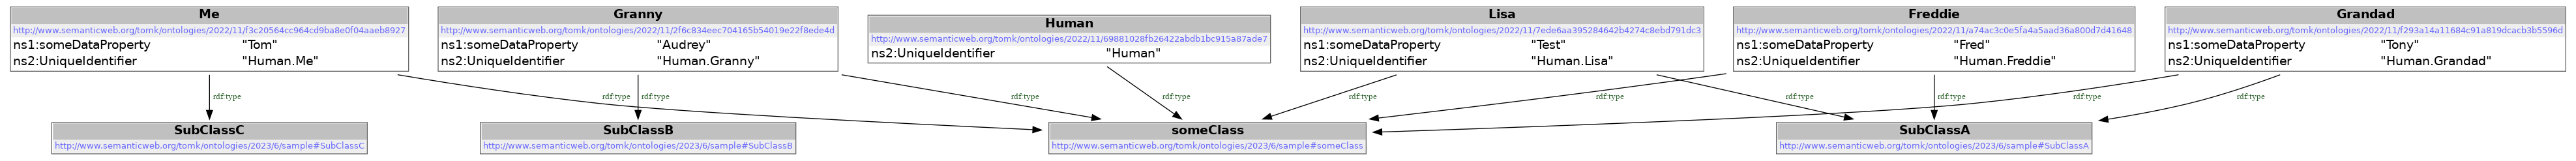

In [41]:
visualize(t2rdflibg(s2))

In [ ]:
[len(q) for q in [L,I,R]]

In [ ]:
#discourse_contents[discourse_contents['p']==][['s','p','o']]
discourse_contents[['s','p','o']].groupby("p").agg(set).loc[URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#type')]['o']



In [ ]:
discourses

In [ ]:
visualize(t2rdflibg( discourse_contents[discourse_contents['discourse']==discourses[1]][['s','p','o']].values))

In [ ]:
dir(ET)

In [ ]:
ET.register_namespace('rdf',"http://www.w3.org/1999/02/22-rdf-syntax-ns#")





In [ ]:
ns_map = [('rdf',"http://www.w3.org/1999/02/22-rdf-syntax-ns#"),
          ('dc',"http://purl.org/dc/elements/1.1/"),
          ('rdfs',"http://www.w3.org/2000/01/rdf-schema#")
         ]
name = "http://master"
g_context = { "dc:created" : datetime.now().strftime("%Y-%m-%d"),
              "dc:description":"""The master graph is used to store all mastered triples. It acts as a "soup" of expressable content, primarily for entities to be identified by their properties for the purposes of identifying unique individuals. """}

g_context

In [ ]:

def create_named_graph_manifest_rdf_xml(graph_uri, namespaces, properties):
    X = ET.Element('rdf:RDF')
    for prefix, uri  in namespaces:
        X.set("xmlns:" + prefix, uri)
    q = ET.SubElement(X, "rdf:Description")
    q.set("rdf:about", graph_uri)
    for t,v in g_context.items():
        a = ET.SubElement(q, t)
        a.text = v
    ET.indent(X, space="\t", level=0)
    return ET.tostring(X).decode()

In [ ]:
xml_text = create_named_graph_manifest_rdf_xml("http://master", ns_map, g_context)
print(xml_text)